<a href="https://colab.research.google.com/github/PeixotoJr/ADD/blob/main/Series_Temporais_SELIC_IPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install python-bcb

# Importação de Bibliotecas
* pandas: Biblioteca para manipulação e análise de
dados. Usada para carregar e manipular os dados das séries temporais.
* matplotlib.pyplot: Biblioteca para criação de gráficos. Usada para plotar os dados e previsões.
* seaborn: Biblioteca para visualização de dados que trabalha sobre o matplotlib. (Não está sendo utilizada diretamente no código, mas é importada e pode ser usada para aprimorar visualizações.)
* statsmodels.api: Biblioteca para modelagem estatística. Inclui a função AutoReg para criar modelos autoregressivos.
 AutoReg: Classe da statsmodels para criar modelos autoregressivos.
* requests: Biblioteca para fazer requisições HTTP. Usada para baixar os dados da API do Banco Central.
* StringIO: Classe do módulo io para manipular strings como arquivos. Usada para ler os dados CSV obtidos pela requisição HTTP.

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
import requests
from io import StringIO
from bcb import sgs
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Função para Baixar Dados
* series_id: Identificador da série temporal a ser baixada (IPCA ou SELIC).
* start_date e end_date: Datas de início e fim para o período desejado.
* url: Constrói a URL da API do Banco Central para baixar os dados no formato CSV.
* requests.get(url): Faz a requisição HTTP para obter os dados.
* pd.read_csv(StringIO(response.text), sep=';'): Lê os dados CSV da resposta HTTP, usando StringIO para tratar o texto como um arquivo.
* data['data']: Converte a coluna de datas para o formato datetime.
* data['valor']: Substitui a vírgula por ponto na coluna de valores e converte para tipo float.

In [20]:
# Lista de códigos das séries desejadas
codigos = [433,4391]  # Exemplo: 433 é a Taxa Selic, 433 é o IPCA, 11 é o PIB

In [21]:
# Dicionário para armazenar os dados das séries
series = {}
# Definir a data final como o dia atual
data_final = pd.to_datetime('today')
# Definir a data inicial como X anos atrás
data_inicial = data_final - pd.DateOffset(years=10)
# Converter as datas para o formato correto
data_inicial = data_inicial.strftime('%Y-%m-%d')
data_final = data_final.strftime('%Y-%m-%d')

In [22]:
# Obter as séries do SGS
for codigo in codigos:
    series[codigo] = sgs.get(codigo, start=data_inicial, end=data_final)
    # Obter a série do Banco Central com o intervalo

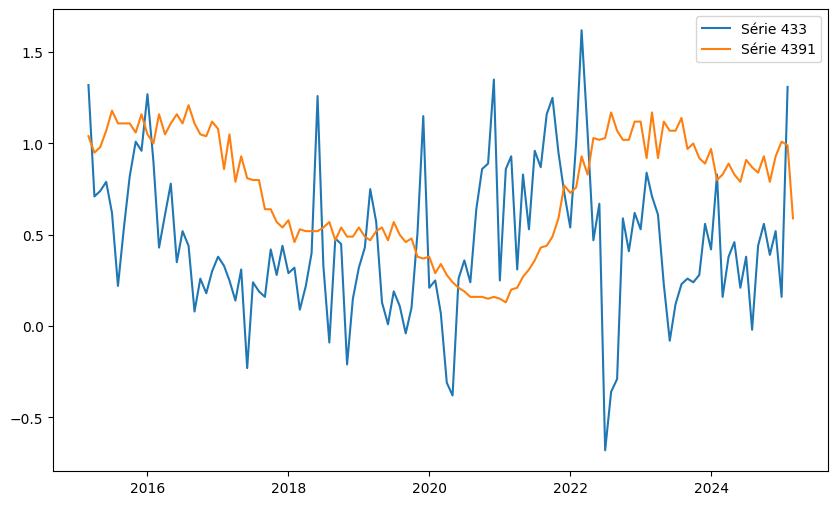

In [23]:
# Plotar as séries
plt.figure(figsize=(10, 6))
for codigo, serie in series.items():
    plt.plot(serie.index, serie.values, label=f'Série {codigo}')
    plt.legend()  # Adiciona a legenda
    #plt.xlabel('Eixo X')  # Opcional: Nome do eixo X
    #plt.ylabel('Eixo Y')  # Opcional: Nome do eixo Y
    #plt.title('Gráfico das Séries')  # Opcional: Título do gráfico
plt.show()

In [58]:
df = pd.concat(series.values(), axis=1)
df = df.dropna()
print(df.head())

             433  4391
Date                  
2015-03-01  1.32  1.04
2015-04-01  0.71  0.95
2015-05-01  0.74  0.98
2015-06-01  0.79  1.07
2015-07-01  0.62  1.18


# Configuração e Download dos Dados


*  start_date e end_date: Define o intervalo para os dados.
* ipca_id e selic_id: IDs das séries temporais IPCA e SELIC na API.
* download_bc_data(...): Chama a função para baixar os dados das séries.



In [59]:
fig = go.Figure()

# Adicionar uma linha para cada série
for col in df.columns:
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df[col].values.flatten(),  # Flatten para garantir 1D
        mode='lines+markers',
        name=f'Série {col}'
    ))

# 3. Customizar layout
fig.update_layout(
    title='Séries Temporais Interativas',
    xaxis_title='Data',
    yaxis_title='Valor',
    hovermode='x unified',
    template='plotly_white',
    legend_title='Séries'
)

# 4. Exibir gráfico
fig.show()

AttributeError: 'tuple' object has no attribute 'dropna'

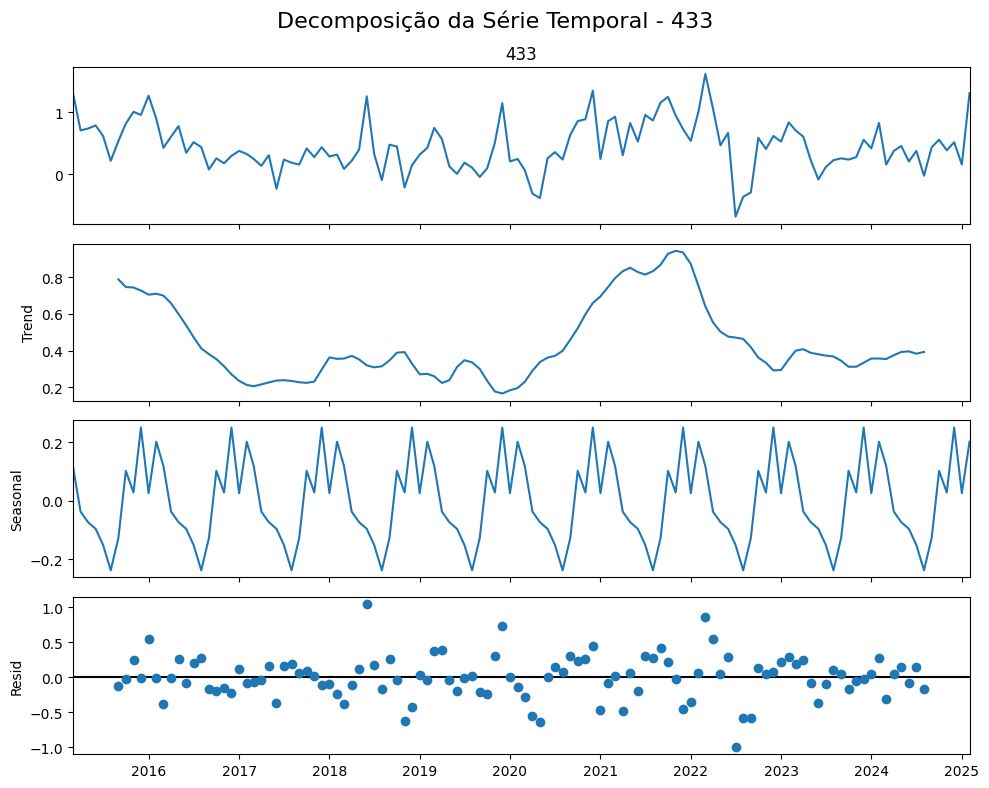

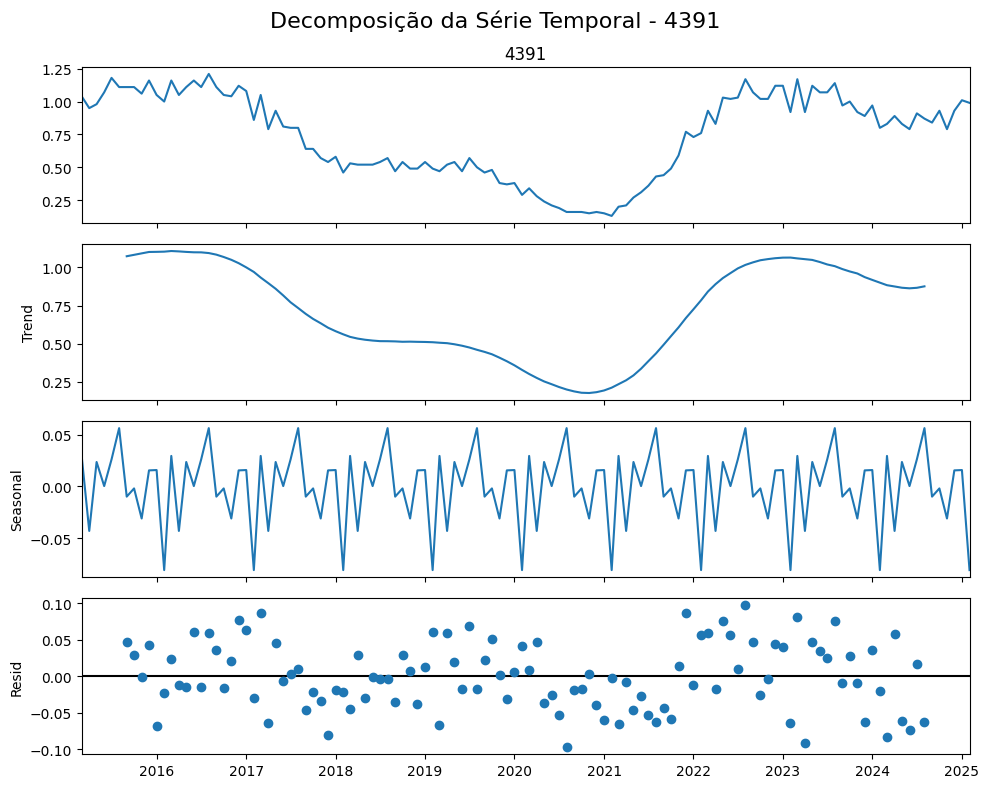

In [62]:
# Para cada série
for col in df.columns:
    y = df[col].values.flatten()  # Flatten correto, sem vírgula no final
    decomposition = sm.tsa.seasonal_decompose(
        df[col],  # Passa diretamente a série com índice Date
        model='additive',
        period=12  # Periodicidade mensal (1 ano)
    )

    # Plot
    fig = decomposition.plot()
    fig.set_size_inches(10, 8)
    plt.suptitle(f'Decomposição da Série Temporal - {col}', fontsize=16)
    plt.tight_layout()
    plt.show()

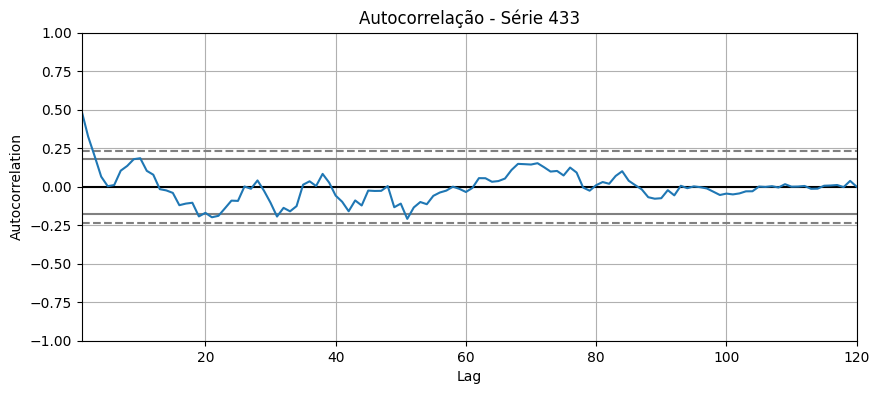

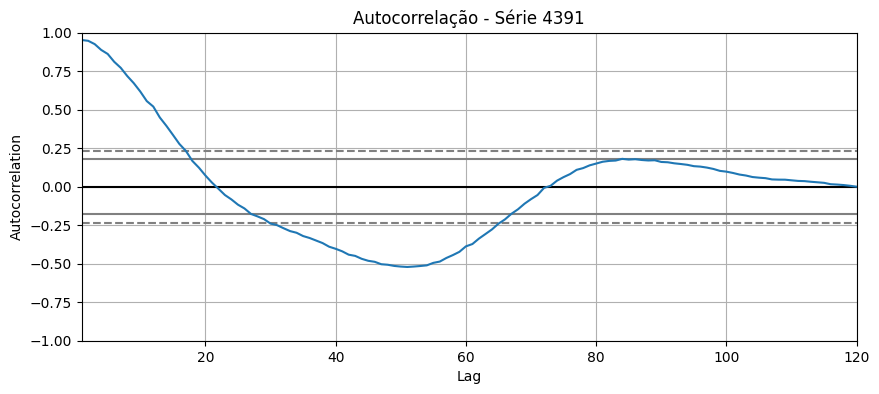

In [63]:
# Loop para cada série no DataFrame df
for col in df.columns:
    plt.figure(figsize=(10, 4))
    pd.plotting.autocorrelation_plot(df[col])
    plt.title(f'Autocorrelação - Série {col}')
    plt.show()

# Ajuste do Modelo AR para IPCA e SELIC
* AutoReg(...): Cria um modelo autoregressivo usando os dados e o número de lags (12 meses, neste caso).
* fit(): Ajusta o modelo aos dados.
* predict(start=0, end=len(...) - 1): Faz previsões com base no modelo ajustado, para todos os pontos de dados disponíveis.


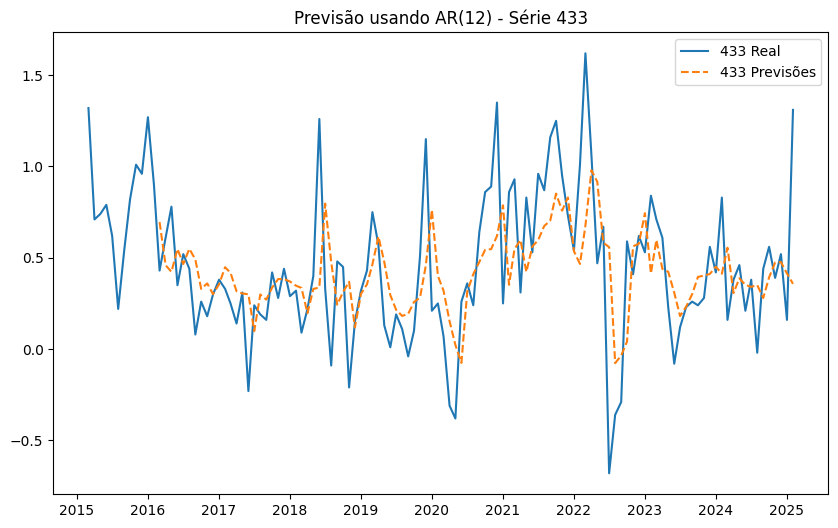

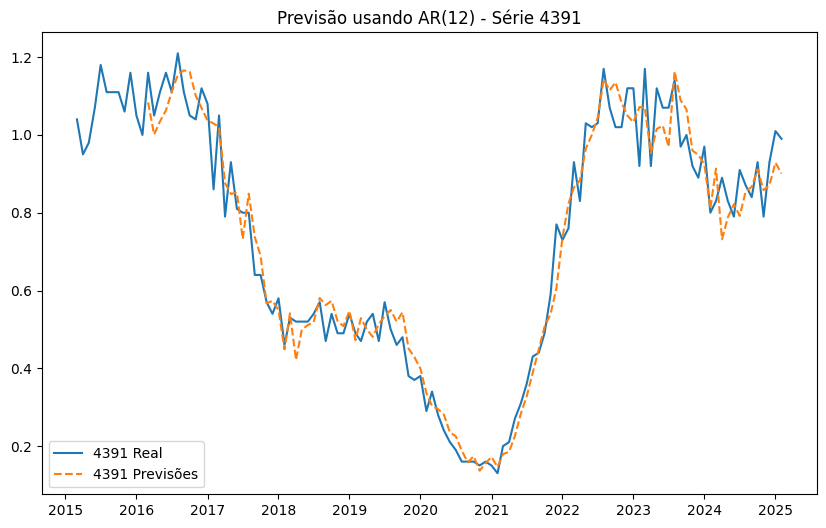

In [64]:
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt

# Loop para cada série no DataFrame df
for col in df.columns:
    # Ajuste do modelo AR para a série atual
    model = AutoReg(df[col], lags=12)  # Usando 12 lags para o modelo AR
    model_fitted = model.fit()  # Ajusta o modelo
    predictions = model_fitted.predict(start=0, end=len(df[col]) - 1)  # Faz a previsão

    # Plotando as previsões
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[col], label=f'{col} Real')  # Série original
    plt.plot(df.index, predictions, label=f'{col} Previsões', linestyle='--')  # Previsões do modelo AR
    plt.title(f'Previsão usando AR(12) - Série {col}')
    plt.legend()
    plt.show()


# Plot dos Gráficos com Previsões

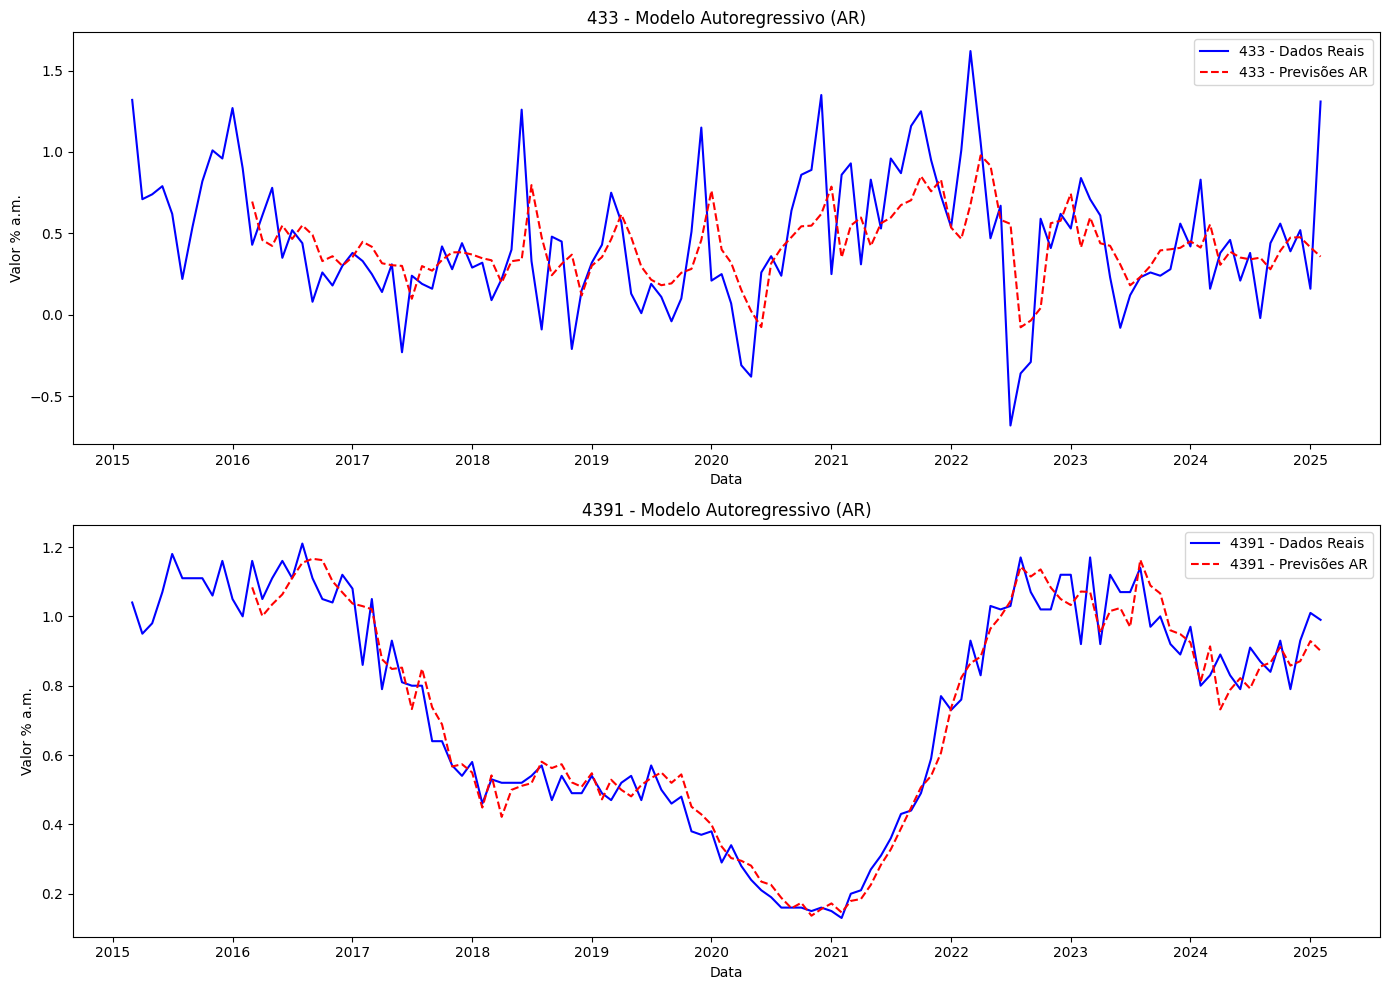

In [65]:
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

# Loop para cada série no DataFrame df
plt.figure(figsize=(14, 10))  # Tamanho maior para acomodar vários gráficos

for i, col in enumerate(df.columns, 1):
    # Ajuste do modelo AR para cada série
    model = AutoReg(df[col], lags=12)  # Usando 12 lags para o modelo AR
    model_fitted = model.fit()  # Ajusta o modelo
    predictions = model_fitted.predict(start=0, end=len(df[col]) - 1)  # Faz a previsão

    # Criando subgráficos
    plt.subplot(len(df.columns), 1, i)  # Define a posição do gráfico (em linhas)

    # Plotando os dados reais e as previsões
    plt.plot(df.index, df[col], label=f'{col} - Dados Reais', color='blue')
    plt.plot(df.index, predictions, label=f'{col} - Previsões AR', color='red', linestyle='--')

    # Adicionando título, rótulos e legenda
    plt.title(f'{col} - Modelo Autoregressivo (AR)')
    plt.xlabel('Data')
    plt.ylabel('Valor % a.m.')
    plt.legend()

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo os gráficos
plt.show()

In [66]:
# Loop para cada série no DataFrame df
for col in df.columns:
    # Ajuste do modelo AR para a série atual
    model = AutoReg(df[col], lags=12)  # Usando 12 lags para o modelo AR
    model_fitted = model.fit()  # Ajusta o modelo

    # Exibição dos parâmetros do modelo
    print(f"Parâmetros do modelo AR para a série {col}:")
    print(model_fitted.params)  # Exibe os parâmetros do modelo AR
    print("\n")

Parâmetros do modelo AR para a série 433:
const      0.177102
433.L1     0.422700
433.L2     0.094207
433.L3     0.049645
433.L4    -0.077007
433.L5    -0.016667
433.L6    -0.068221
433.L7     0.085845
433.L8     0.004673
433.L9     0.071473
433.L10    0.048286
433.L11   -0.062897
433.L12    0.022569
dtype: float64


Parâmetros do modelo AR para a série 4391:
const       0.025537
4391.L1     0.388988
4391.L2     0.614767
4391.L3     0.366876
4391.L4    -0.165239
4391.L5     0.056994
4391.L6    -0.092319
4391.L7    -0.053013
4391.L8    -0.041313
4391.L9    -0.012876
4391.L10   -0.202264
4391.L11   -0.234528
4391.L12    0.341158
dtype: float64




<ipython-input-67-fabcb955c100>:17: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



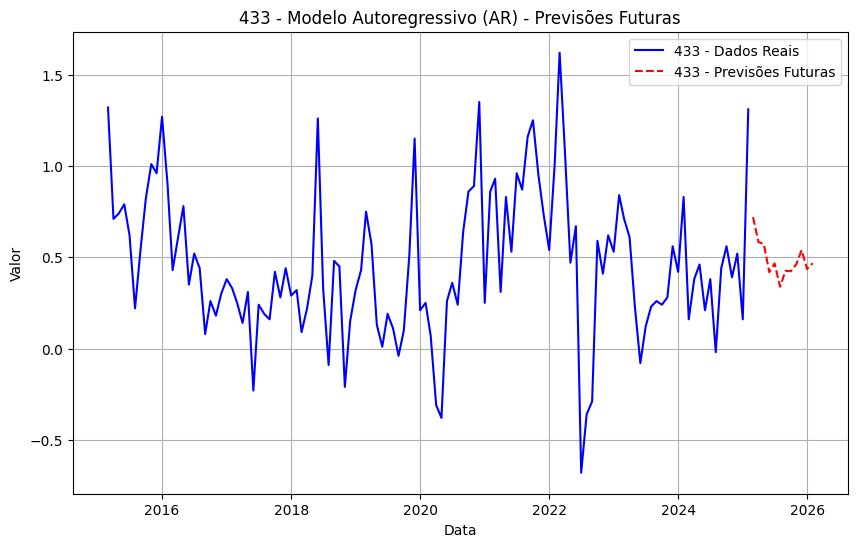

<ipython-input-67-fabcb955c100>:17: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



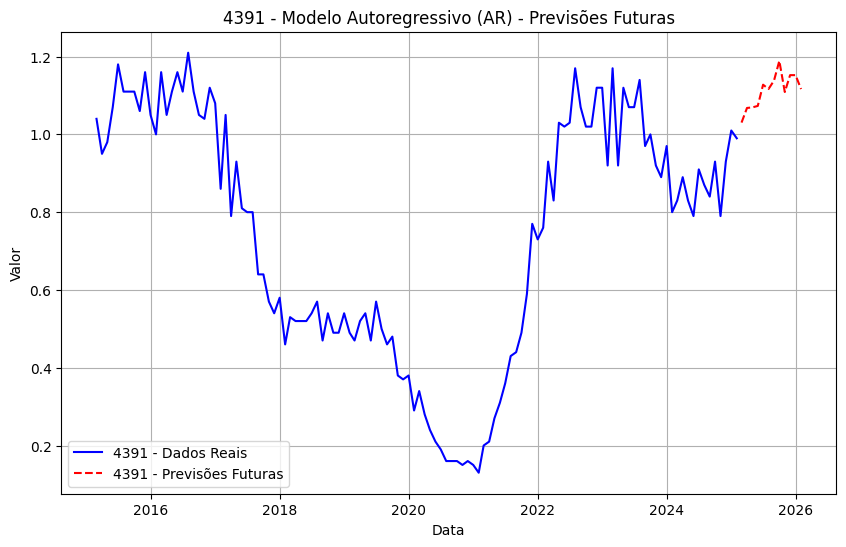

In [67]:
# Definir o número de períodos futuros que queremos prever
n_periods = 12  # Exemplo: prever os próximos 12 meses

# Criar um DataFrame para armazenar as previsões
predictions_df = pd.DataFrame()

# Loop para cada série no DataFrame df
for col in df.columns:
    # Ajuste do modelo AR para a série atual
    model = AutoReg(df[col], lags=12)  # Usando 12 lags para o modelo AR
    model_fitted = model.fit()  # Ajusta o modelo

    # Previsões futuras
    forecast = model_fitted.predict(start=len(df), end=len(df) + n_periods - 1)

    # Adicionar as previsões ao DataFrame de previsões
    future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=n_periods, freq='M')
    predictions_df[col] = forecast

    # Plotando os dados reais e as previsões
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[col], label=f'{col} - Dados Reais', color='blue')
    plt.plot(future_dates, forecast, label=f'{col} - Previsões Futuras', color='red', linestyle='--')
    plt.title(f'{col} - Modelo Autoregressivo (AR) - Previsões Futuras')
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()

In [68]:
# Exportar as previsões para um arquivo CSV
predictions_df.index = future_dates  # Definir as datas futuras como índice
predictions_df.to_csv('previsoes_futuras.csv', index=True)

print("Previsões futuras exportadas para 'previsoes_futuras.csv'")

Previsões futuras exportadas para 'previsoes_futuras.csv'
